In [1]:
import os
import sys
import random
import warnings

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = "./U_NET/train/"
TEST_PATH = "./U_NET/validation/"

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


Collect our files names for train and test data

In [2]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

Creating the image masks of dimension 128 x 128 (only for black images)

In [3]:
print("Getting and resizing all the training images\n")

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

Getting and resizing all the training images



Let's use TQDM to create our progress bars

In [4]:
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 
Getting and resizing test images ... 
Done!


100%|██████████| 65/65 [00:01<00:00, 42.05it/s]


Illustrate the train images and masks

/home/borin/anaconda3/envs/CursoDLECV/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


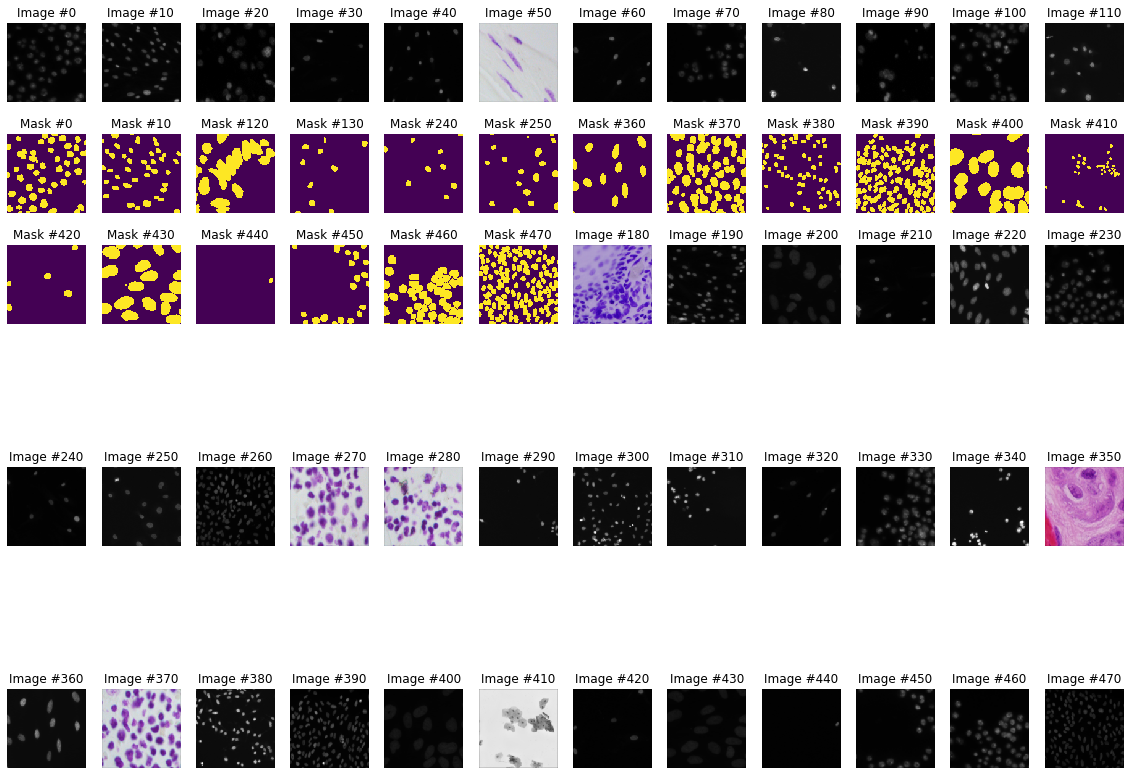

In [5]:
plt.figure(figsize = (20, 16))
x, y = 12, 4

for i in range(y):
    
    for j in range(x):
        
        plt.subplot(y * 2, x, i * 2 * x + j + 1)
        pos = i * 120 + j * 10
        plt.imshow(X_train[pos])
        plt.title("Image #{}".format(pos))
        plt.axis("off")
        plt.subplot(y * 2, x, i * 2 + 1 * x + j + 1)
        
        # We now display the associated mask we just generated above with the training image
        plt.imshow(np.squeeze(Y_train[pos]))
        plt.title("Mask #{}".format(pos))
        plt.axis("off")

plt.show()

Now, let's define a custom metric called Intersection over union (IoU)

In [6]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

Build our U-Net Model

In [7]:
K.clear_session()

# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[my_iou_metric])
model.summary()









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)       

Fit our Model

In [8]:
modelPath = "./NucleiFinder.h5"

checkpoint = ModelCheckpoint(modelPath, monitor = "val_loss",
                            mode = "min", save_best_only = True,
                            verbose = 1)

earlyStop = EarlyStopping(monitor = "val_loss", min_delta = 0,
                          patience = 5, verbose = 1,
                          restore_best_weights = True)

# Fit Our Model
results = model.fit(X_train, Y_train, validation_split = 0.1,
                    batch_size = 8, epochs = 5,
                    callbacks = [earlyStop, checkpoint])




Train on 603 samples, validate on 67 samples
Epoch 1/5





603/603 [==============================] - 45s 74ms/step - loss: 0.6411 - my_iou_metric: 0.0229 - val_loss: 0.4839 - val_my_iou_metric: 0.0680

Epoch 00001: val_loss improved from inf to 0.48395, saving model to ./NucleiFinder.h5
Epoch 2/5
603/603 [==============================] - 43s 71ms/step - loss: 0.4019 - my_iou_metric: 0.0831 - val_loss: 0.3630 - val_my_iou_metric: 0.1520

Epoch 00002: val_loss improved from 0.48395 to 0.36299, saving model to ./NucleiFinder.h5
Epoch 3/5
603/603 [==============================] - 43s 71ms/step - loss: 0.2677 - my_iou_metric: 0.2056 - val_loss: 0.1637 - val_my_iou_metric: 0.3347

Epoch 00003: val_loss improved from 0.36299 to 0.16365, saving model to ./NucleiFinder.h5
Epoch 4/5
603/603 [==============================] - 42s 70ms/step - loss: 1.1635 - my_iou_metric: 0.1683 - val_loss: 3.1398 - val_my_iou_metric: 0.0000e+00

Epoch 00004: val_loss did not improve from 0.16365
Epoch 5/5


In [9]:
# Predict on train, val and test
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 1s 12ms/step


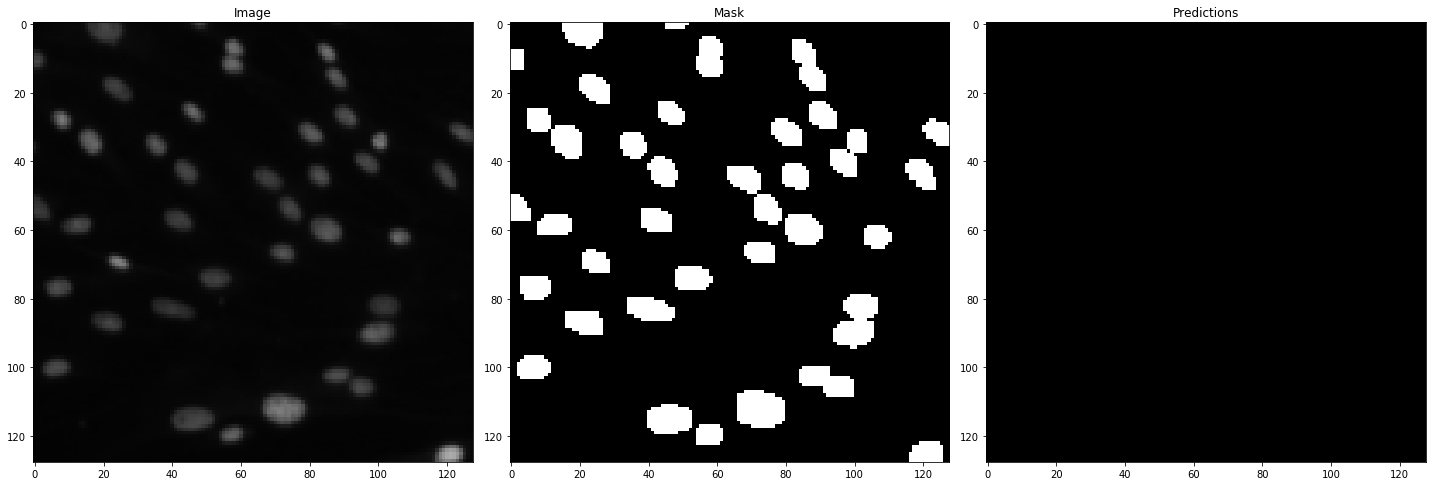

In [10]:
ix = 10
plt.figure(figsize=(20,20))
plt.subplot(131)
imshow(X_train[ix])
plt.title("Image")
plt.subplot(132)
imshow(np.squeeze(Y_train[ix]))
plt.title("Mask")
plt.subplot(133)
imshow(np.squeeze(preds_train_t[ix] > 0.5))
plt.title("Predictions")
plt.show()

In [11]:
iou_metric(np.squeeze(Y_train[ix]), np.squeeze(preds_train_t[ix]), print_table=True)

Thresh	TP	FP	FN	Prec.
0.500	0	0	35	0.000
0.550	0	0	35	0.000
0.600	0	0	35	0.000
0.650	0	0	35	0.000
0.700	0	0	35	0.000
0.750	0	0	35	0.000
0.800	0	0	35	0.000
0.850	0	0	35	0.000
0.900	0	0	35	0.000
0.950	0	0	35	0.000
AP	-	-	-	0.000


0.0

Testing with a second model

In [12]:
from keras.layers import Dropout

K.clear_session()

# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x ) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D(pool_size=(2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[my_iou_metric])
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]              

In [13]:
modelPath = "./NucleiFinder2.h5"

checkpoint = ModelCheckpoint(modelPath, monitor = "val_loss",
                            mode = "min", save_best_only = True,
                            verbose = 1)

earlyStop = EarlyStopping(monitor = "val_loss", min_delta = 0,
                          patience = 5, verbose = 1,
                          restore_best_weights = True)

# Fit Our Model
results = model.fit(X_train, Y_train, validation_split = 0.1,
                    batch_size = 8, epochs = 10,
                    callbacks = [earlyStop, checkpoint])

Train on 603 samples, validate on 67 samples
Epoch 1/10
603/603 [==============================] - 116s 192ms/step - loss: 0.5819 - my_iou_metric: 0.0199 - val_loss: 0.3564 - val_my_iou_metric: 0.0544

Epoch 00001: val_loss improved from inf to 0.35641, saving model to ./NucleiFinder2.h5
Epoch 2/10
603/603 [==============================] - 108s 180ms/step - loss: 0.2151 - my_iou_metric: 0.1379 - val_loss: 0.1766 - val_my_iou_metric: 0.2916

Epoch 00002: val_loss improved from 0.35641 to 0.17662, saving model to ./NucleiFinder2.h5
Epoch 3/10
603/603 [==============================] - 110s 183ms/step - loss: 0.1613 - my_iou_metric: 0.3148 - val_loss: 0.1602 - val_my_iou_metric: 0.3636

Epoch 00003: val_loss improved from 0.17662 to 0.16020, saving model to ./NucleiFinder2.h5
Epoch 4/10
603/603 [==============================] - 110s 182ms/step - loss: 0.1387 - my_iou_metric: 0.4102 - val_loss: 0.1145 - val_my_iou_metric: 0.4735

Epoch 00004: val_loss improved from 0.16020 to 0.11453, sa

In [14]:
# Predict on train, val and test
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 3s 46ms/step


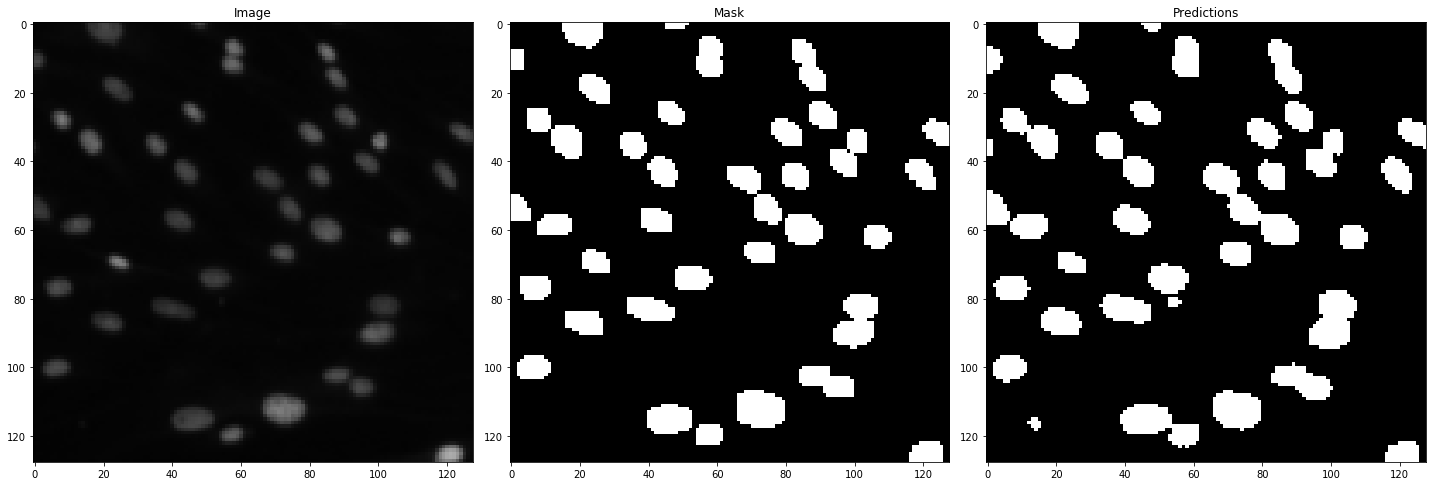

In [15]:
ix = 10
plt.figure(figsize=(20,20))
plt.subplot(131)
imshow(X_train[ix])
plt.title("Image")
plt.subplot(132)
imshow(np.squeeze(Y_train[ix]))
plt.title("Mask")
plt.subplot(133)
imshow(np.squeeze(preds_train_t[ix] > 0.5))
plt.title("Predictions")
plt.show()

Ploting the Loss Charts 

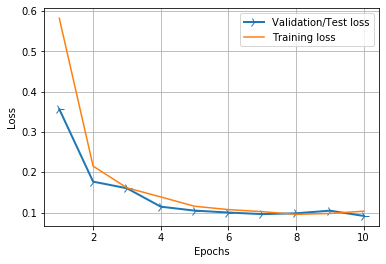

In [16]:
historyDict = results.history

lossValues = historyDict["loss"]
valLossValues = historyDict["val_loss"]
epochs = range(1, len(lossValues) + 1)

line1 = plt.plot(epochs, valLossValues, label = "Validation/Test loss")
line2 = plt.plot(epochs, lossValues, label = "Training loss")
plt.setp(line1, linewidth = 2.0, marker = "+", markersize = 10.0)
plt.setp(line1, linewidth = 2.0, marker = "4", markersize = 10.0)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

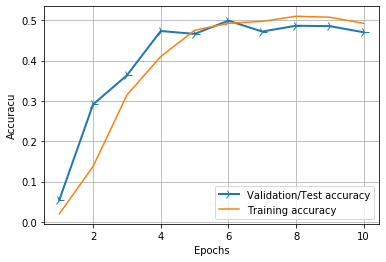

In [17]:
accValues = historyDict["my_iou_metric"]
valAccValues = historyDict["val_my_iou_metric"]

line1 = plt.plot(epochs, valAccValues, label = "Validation/Test accuracy")
line2 = plt.plot(epochs, accValues, label = "Training accuracy")
plt.setp(line1, linewidth = 2.0, marker = "+", markersize = 10.0)
plt.setp(line1, linewidth = 2.0, marker = "4", markersize = 10.0)
plt.xlabel("Epochs")
plt.ylabel("Accuracu")
plt.grid(True)
plt.legend()
plt.show()